In [1]:
!pip install -U braindecode==1.2.0 mne==1.10.1 mne-bids==0.17.0 --quiet
!pip install -U eegdash==0.3.8 s3fs==2025.9.0 fsspec==2025.9.0 pandas==2.3.3 --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 109.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.9/168.9 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 117.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pand

In [2]:
from pathlib import Path
import os, math, random
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from sklearn.preprocessing import StandardScaler

from braindecode.preprocessing import create_fixed_length_windows
from braindecode.datasets.base import BaseConcatDataset, BaseDataset, EEGWindowsDataset
from braindecode.models import EEGNetv4  # EEGNet architecture implemented in Braindecode

from eegdash import EEGChallengeDataset

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
seed_all(42)
print("Device:", device)

# Sampling rate defined early
SFREQ = 100  # competition downsampled rate

Device: cuda


Loading data for one release

In [6]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

release = "R5"                    # single public validation release (mini)
task_name = "contrastChangeDetection"
mini_mode = True                  # keep mini for Colab/Kaggle prototyping
desc_fields = ["subject","session","run","task","age","sex","gender","handedness","p_factor"]

dataset = EEGChallengeDataset(
    release=release,
    task=task_name,
    mini=mini_mode,
    description_fields=desc_fields,
    cache_dir=DATA_DIR,
)
bcd_raw = BaseConcatDataset([dataset])
print("Raw rows:", len(bcd_raw.datasets))
print(pd.DataFrame(bcd_raw.description).head())

/usr/local/lib/python3.12/dist-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


Raw rows: 60
        subject  run                     task     age sex  p_factor  \
0  NDARAH793FBF    1  contrastChangeDetection  9.3427   M     0.317   
1  NDARAH793FBF    2  contrastChangeDetection  9.3427   M     0.317   
2  NDARAH793FBF    3  contrastChangeDetection  9.3427   M     0.317   
3  NDARAJ689BVN    2  contrastChangeDetection  5.4878   F     0.084   
4  NDARAJ689BVN    3  contrastChangeDetection  5.4878   F     0.084   

  release_number  ehq_total commercial_use full_pheno  ...  thepresent  \
0             R5      60.03            Yes         No  ...   available   
1             R5      60.03            Yes         No  ...   available   
2             R5      60.03            Yes         No  ...   available   
3             R5      46.69            Yes         No  ...   available   
4             R5      46.69            Yes         No  ...   available   

   diaryofawimpykid  contrastchangedetection_1 contrastchangedetection_2  \
0         available                  av

Filtering and splitting

In [8]:
sub_rm = ["NDARAH793FBF","NDARAH793FBF","NDARAH793FBF","NDARAJ689BVN"," NDARAJ689BVN"]
def filter_dataset(bcd: BaseConcatDataset):

    kept = []
    for ds in bcd.datasets:
        ok = (
            ds.description["subject"] not in sub_rm
            and not math.isnan(float(ds.description.get("p_factor", np.nan)))
            and ds.raw.n_times >= 4 * SFREQ
            and len(ds.raw.ch_names) == 129
        )
        if ok:
            kept.append(ds)
    return BaseConcatDataset(kept)

bcd = filter_dataset(bcd_raw)
print("Filtered rows:", len(bcd.datasets))

# Subject-wise split within R5 (single release)
subjects = sorted(set([ds.description["subject"] for ds in bcd.datasets]))
rng = np.random.RandomState(42)
rng.shuffle(subjects)
if len(subjects) >= 10:
    n_val = max(1, int(round(0.2 * len(subjects))))
else:
    n_val = 1
val_subjects = set(subjects[:n_val])
train_subjects = set(subjects[n_val:])

def subset_by_subjects(bcd: BaseConcatDataset, subj_set: set):
    return BaseConcatDataset([ds for ds in bcd.datasets if ds.description["subject"] in subj_set])

train_bcd = subset_by_subjects(bcd, train_subjects)
val_bcd   = subset_by_subjects(bcd, val_subjects)
print(f"Train subjects: {len(train_subjects)} | Val subjects: {len(val_subjects)}")


Filtered rows: 51
Train subjects: 14 | Val subjects: 3


Dataset wrapper w/ demographics

In [36]:
class DatasetWrapper(BaseDataset):

    def __init__(self, dataset: EEGWindowsDataset, crop_size_samples: int, seed=None):
        self.dataset = dataset
        self.crop_size_samples = crop_size_samples
        self.rng = random.Random(seed)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        X, _, crop_inds = self.dataset[index]

        # Label
        y = torch.tensor(float(self.dataset.description["p_factor"]), dtype=torch.float32)

        # Build full demo = [age, sex, hand]
        age = self.dataset.description.get("age", np.nan)
        age = float(age) if age is not None and age == age else np.nan
        sex_str = str(self.dataset.description.get("sex", self.dataset.description.get("gender", ""))).strip().lower()
        sex = 1.0 if sex_str in ["female","f","2"] else 0.0 if sex_str not in ["", "nan"] else np.nan
        hand = self.dataset.description.get("handedness", np.nan)
        hand = float(hand) if hand is not None and hand == hand else np.nan

        full_demo = np.array([age, sex, hand], dtype=np.float32)

        # Select only kept columns
        if demo_dim > 0:
            demo_np = full_demo[keep_idx]
            # Do not impute here; raw NaNs will be handled in transform function
            demo = torch.from_numpy(demo_np)
        else:
            demo = torch.empty(0, dtype=torch.float32)  # zero-dim


        infos = {
            "subject": self.dataset.description["subject"],
            "task": self.dataset.description["task"],
            "session": self.dataset.description.get("session", "") or "",
            "run": self.dataset.description.get("run", "") or "",
        }

        # Random 2 s crop inside a 4 s window
        i_window_in_trial, i_start, i_stop = crop_inds
        crop_len = 2 * SFREQ
        assert (i_stop - i_start) >= crop_len, f"Window too short: {(i_stop - i_start)} < {crop_len}"
        start_offset = self.rng.randint(0, (i_stop - i_start) - crop_len)
        X = X[:, start_offset : start_offset + crop_len]  # X may be numpy here

        # Convert to torch tensor (C, T) float32
        if not torch.is_tensor(X):
            X = torch.from_numpy(np.asarray(X))

        X = X.to(torch.float32)

        # Per-window standardization with epsilon, then sanitize
        mu = X.mean(dim=1, keepdim=True)
        sd = X.std(dim=1, keepdim=True)
        X = (X - mu) / (sd + 1e-6)

        # Replace NaN/Inf with zeros and clamp extreme amplitudes
        X = torch.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
        X = torch.clamp(X, min=-1e3, max=1e3)

        return X, y, demo, (i_window_in_trial, i_start, i_stop), infos


Fit demo scaler on train subjects

In [38]:
def extract_unique_demo(bcd: BaseConcatDataset):
    seen = {}
    for ds in bcd.datasets:
        sid = ds.description["subject"]
        if sid in seen:
            continue
        age = ds.description.get("age", np.nan)
        age = float(age) if age is not None and age == age else np.nan
        sex_str = str(ds.description.get("sex", ds.description.get("gender", ""))).strip().lower()
        sex = 1.0 if sex_str in ["female","f","2"] else 0.0
        hand = ds.description.get("handedness", np.nan)
        hand = float(hand) if hand is not None and hand == hand else np.nan
        seen[sid] = [age, sex, hand]
    arr = np.array(list(seen.values()), dtype=np.float32) if seen else np.zeros((0,3), dtype=np.float32)
    return arr

train_demo_unique = extract_unique_demo(train_bcd)  # shape [N_subj, 3] for [age, sex, hand]
if train_demo_unique.shape[0] == 0:
    train_demo_unique = np.zeros((1,3), dtype=np.float32) * np.nan

# Identify all-NaN columns
all_nan_cols = np.isnan(train_demo_unique).all(axis=0)  # [age, sex, hand]
keep_mask = ~all_nan_cols
keep_names = [n for n, k in zip(["age","sex","hand"], keep_mask) if k]
keep_idx = np.where(keep_mask)[0]
print("Keeping demo columns:", keep_names)

# Reduce to kept columns
train_demo_kept = train_demo_unique[:, keep_idx]
# If nothing remains, fall back to zero-dim demo (disable late fusion)
if train_demo_kept.shape[1] == 0:
    print("No usable demographic columns; disabling late fusion.")
    demo_dim = 0
else:
    demo_dim = train_demo_kept.shape[1]

if demo_dim > 0:
    # Impute remaining NaNs per kept column with column medians (now each column has at least one finite)
    with np.errstate(all="ignore"):
        col_medians = np.nanmedian(train_demo_kept, axis=0).astype(np.float32)
    col_medians[~np.isfinite(col_medians)] = 0.0  # safety
    def impute_cols(arr, meds):
        out = arr.copy()
        for j in range(out.shape[1]):
            mask = ~np.isfinite(out[:, j])
            out[mask, j] = meds[j]
        return out
    train_demo_imp = impute_cols(train_demo_kept, col_medians)

    class SafeStandardScaler(StandardScaler):
        def fit(self, X, y=None):
            super().fit(X, y)
            if hasattr(self, "scale_"):
                bad = ~np.isfinite(self.scale_) | (self.scale_ == 0)
                self.scale_[bad] = 1.0
            if hasattr(self, "var_"):
                self.var_[~np.isfinite(self.var_)] = 0.0
            if hasattr(self, "mean_"):
                self.mean_[~np.isfinite(self.mean_)] = 0.0
            return self

    demo_scaler = SafeStandardScaler().fit(train_demo_imp)
    print("Demo scaler fitted on", train_demo_imp.shape[0], "subjects | dims:", demo_dim)
else:
    demo_scaler = None

@torch.no_grad()
def transform_demo_batch(demo_t: torch.Tensor):
    dev = torch.device(device) if not isinstance(device, torch.device) else device
    if demo_t.numel() == 0:  # demo_dim=0
        return demo_t.to(device=dev)

    demo_np = demo_t.detach().cpu().numpy().astype(np.float32)  # shape [B, demo_dim]
    # Impute per kept column using col_medians
    for j in range(demo_np.shape[1]):
        mask = ~np.isfinite(demo_np[:, j])
        demo_np[mask, j] = col_medians[j]
    demo_np = demo_scaler.transform(demo_np)
    demo = torch.from_numpy(demo_np).to(device=dev, dtype=torch.float32)
    demo = torch.nan_to_num(demo, nan=0.0, posinf=0.0, neginf=0.0)
    return demo


Keeping demo columns: ['age', 'sex']
Demo scaler fitted on 14 subjects | dims: 2


Windowing and DataLoaders

In [39]:
def make_windows(bcd: BaseConcatDataset, crop_seconds=2):
    windows = create_fixed_length_windows(
        bcd,
        window_size_samples=4 * SFREQ,
        window_stride_samples=2 * SFREQ,
        drop_last_window=True,
    )
    wrapped = [DatasetWrapper(ds, crop_size_samples=crop_seconds * SFREQ, seed=42) for ds in windows.datasets]
    return BaseConcatDataset(wrapped)

train_windows = make_windows(train_bcd, crop_seconds=2)
val_windows   = make_windows(val_bcd,   crop_seconds=2)

num_workers = 1
train_loader = DataLoader(train_windows, batch_size=128, shuffle=True,  num_workers=num_workers)
val_loader   = DataLoader(val_windows,   batch_size=128, shuffle=False, num_workers=num_workers)
print("Batches:", len(train_loader), len(val_loader))

Batches: 48 10


Visualization

Sample window: torch.Size([129, 200]) y: -0.3319999873638153 demo: [7.4098 0.    ] subject: NDARBE091BGD


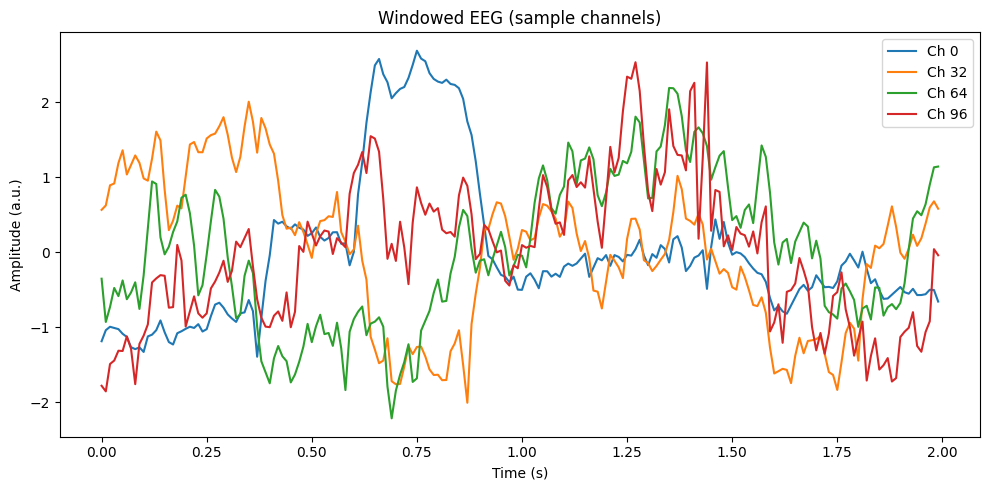

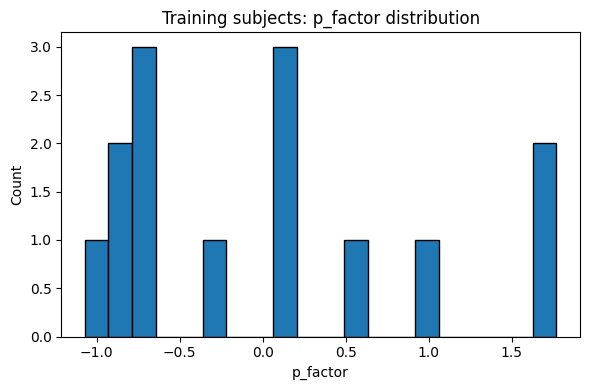

In [40]:
# Sample a window and plot channels
if len(train_windows.datasets) > 0:
    sample_ds = train_windows.datasets[0]
    X_win, y_win, demo_win, _, info_win = sample_ds[0]
    print("Sample window:", X_win.shape, "y:", float(y_win), "demo:", demo_win.numpy(), "subject:", info_win["subject"])

    t = np.arange(X_win.shape[1]) / SFREQ
    plt.figure(figsize=(10, 5))
    for ch in [0, 32, 64, 96]:
        if ch < X_win.shape[0]:
            plt.plot(t, X_win[ch], label=f"Ch {ch}")
    plt.xlabel("Time (s)"); plt.ylabel("Amplitude (a.u.)"); plt.title("Windowed EEG (sample channels)")
    plt.legend(); plt.tight_layout(); plt.show()

# Histogram of training p_factor (unique subjects)
def unique_subject_labels(bcd):
    seen = {}
    for ds in bcd.datasets:
        sid = ds.description["subject"]
        if sid not in seen:
            seen[sid] = float(ds.description["p_factor"])
    return np.array(list(seen.values()), dtype=np.float32) if seen else np.zeros((0,), dtype=np.float32)

train_labels = unique_subject_labels(train_bcd)
if train_labels.size > 0:
    plt.figure(figsize=(6,4))
    plt.hist(train_labels, bins=20, edgecolor="black")
    plt.xlabel("p_factor"); plt.ylabel("Count"); plt.title("Training subjects: p_factor distribution")
    plt.tight_layout(); plt.show()

EEGNetv4 + demographics late fusion

In [41]:
class EEGNetWithDemo(nn.Module):
    def __init__(self, n_chans, n_times, demo_dim=3, feat_dim=16, drop_prob=0.5):
        super().__init__()
        self.backbone = EEGNetv4(n_chans=n_chans, n_outputs=feat_dim, n_times=n_times, drop_prob=drop_prob)
        self.head = nn.Sequential(
            nn.Linear(feat_dim + demo_dim, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.25),
            nn.Linear(64, 1),
        )
    def forward(self, x, demo):
        feat = self.backbone(x)             # [B, feat_dim]
        z = torch.cat([feat, demo], dim=1)  # [B, feat_dim + demo_dim]
        return self.head(z)                 # [B, 1]

if demo_dim > 0:
    model = EEGNetWithDemo(n_chans=129, n_times=2 * SFREQ, demo_dim=demo_dim, feat_dim=16, drop_prob=0.5).to(device)
else:
    # EEG-only: set EEGNetv4 to output 1 directly or keep feat_dim + head with demo_dim=0
    class EEGOnly(nn.Module):
        def __init__(self, n_chans, n_times, feat_dim=16, drop_prob=0.5):
            super().__init__()
            self.backbone = EEGNetv4(n_chans=n_chans, n_outputs=feat_dim, n_times=n_times, drop_prob=drop_prob)
            self.head = nn.Sequential(nn.Linear(feat_dim, 64), nn.ReLU(inplace=True), nn.Dropout(p=0.25), nn.Linear(64, 1))
        def forward(self, x):
            feat = self.backbone(x)
            return self.head(feat)
    model = EEGOnly(n_chans=129, n_times=2 * SFREQ, feat_dim=16, drop_prob=0.5).to(device)

optimizer = torch.optim.Adamax(model.parameters(), lr=0.002, weight_decay=1e-3)
criterion = torch.nn.MSELoss()  # aligns with RMSE/nRMSE scoring
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=3, min_lr=1e-5)
print(model)

EEGNetWithDemo(
  (backbone): EEGNetv4(
    (ensuredims): Ensure4d()
    (dimshuffle): Rearrange('batch ch t 1 -> batch 1 ch t')
    (conv_temporal): Conv2d(1, 8, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (bnorm_temporal): BatchNorm2d(8, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (conv_spatial): ParametrizedConv2dWithConstraint(
      8, 16, kernel_size=(129, 1), stride=(1, 1), groups=8, bias=False
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): MaxNormParametrize()
        )
      )
    )
    (bnorm_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (elu_1): ELU(alpha=1.0)
    (pool_1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (drop_1): Dropout(p=0.5, inplace=False)
    (conv_separable_depth): Conv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=16, bias=False)
    (conv_separable_point): Conv2d(16, 16, kernel_si

<decorator-gen-593>:4: FutureWarning: NOTE: EEGNetv4() is a deprecated class. `EEGNetv4` was renamed to `EEGNet` in v1.12; this alias will be removed in v1.14..


Validation: subject-level nRMSE

In [42]:
@torch.no_grad()
def evaluate_subject_nrmse(model, loader):
    model.eval()
    # Ensure 'device' is a torch.device
    dev = torch.device(device) if not isinstance(device, torch.device) else device

    subj_pred, subj_true = defaultdict(list), {}

    for X, y, demo, crop_inds, infos in loader:
        # Safe casting with keywords
        X = X.to(device=dev, dtype=torch.float32)
        y = y.to(device=dev, dtype=torch.float32).view(-1, 1)
        # If transform_demo_batch returns CPU tensors, move them here:
        demo = transform_demo_batch(demo)  # ensure this returns device=dev
        if demo.device != dev:
            demo = demo.to(device=dev, dtype=torch.float32)

        preds = model(X, demo).squeeze(1).detach().cpu().numpy()
        ys    = y.squeeze(1).detach().cpu().numpy()

        # infos may be list[dict] or a dict; normalize to list of subjects
        subjects = [d["subject"] for d in infos] if isinstance(infos, list) else infos["subject"]
        if not isinstance(subjects, (list, tuple, np.ndarray)):
            subjects = [subjects] * len(preds)

        for i, sid in enumerate(subjects):
            subj_pred[sid].append(float(preds[i]))
            subj_true[sid] = float(ys[i])

    # Aggregate to per-subject predictions
    y_true, y_hat, sids = [], [], []
    for sid, pred_list in subj_pred.items():
        if sid not in subj_true or len(pred_list) == 0:
            continue
        y_true.append(subj_true[sid])
        y_hat.append(float(np.mean(pred_list)))
        sids.append(sid)

    y_true = np.array(y_true, dtype=np.float64)
    y_hat  = np.array(y_hat,  dtype=np.float64)
    if len(y_true) == 0:
        return np.nan, np.nan, np.nan, 0

    rmse  = np.sqrt(np.mean((y_true - y_hat) ** 2))
    std_y = np.std(y_true, ddof=0)
    nrmse = rmse / std_y if std_y > 0 else np.nan

    # Save CSV
    out_path = Path("outputs"); out_path.mkdir(parents=True, exist_ok=True)
    pd.DataFrame({"subject": sids, "p_factor_pred": y_hat}).to_csv(out_path / "val_subject_predictions.csv", index=False)

    return nrmse, rmse, std_y, len(sids)


Training with early stopping

In [43]:
n_epochs = 40
best_nrmse = float("inf")
patience = 8
wait = 0

ckpt_dir = Path("checkpoints"); ckpt_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = ckpt_dir / "best_eegnet_demo_r5.pt"

for epoch in range(1, n_epochs + 1):
    # Train
    model.train()
    train_loss_sum, train_count = 0.0, 0
    for X, y, demo, crop_inds, infos in train_loader:
        optimizer.zero_grad()
        X = X.to(device=device, dtype=torch.float32)
        y = y.to(device=device, dtype=torch.float32).view(-1, 1)
        demo = demo.to(device=device, dtype=torch.float32)
        y_pred = model(X, demo)
        loss = criterion(y_pred, y)
        if not torch.isfinite(y_pred).all() or not torch.isfinite(y).all():
          print("Non-finite detected:", torch.isnan(y_pred).sum().item(), torch.isinf(y_pred).sum().item())
          continue

        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss_sum += loss.item() * X.size(0)
        train_count += X.size(0)
    train_mse = train_loss_sum / max(1, train_count)

    # Validate (subject-level on R5 split)
    nrmse, rmse, std_y, n_subj = evaluate_subject_nrmse(model, val_loader)
    scheduler.step(nrmse if nrmse == nrmse else 1.0)

    print(f"Epoch {epoch:02d} | train MSE={train_mse:.4f} | val nRMSE={nrmse:.4f} | RMSE={rmse:.4f} | std(y)={std_y:.4f} | subjects={n_subj}")

    # Early stopping
    if nrmse < best_nrmse:
        best_nrmse = nrmse
        wait = 0
        torch.save({"model": model.state_dict(), "best_nrmse": best_nrmse}, ckpt_path)
        print(f"  Saved: {ckpt_path} (best nRMSE={best_nrmse:.4f})")
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping at epoch {epoch} (best nRMSE={best_nrmse:.4f})")
            break
torch.save(model.state_dict(), "best_eegnet_demo_r5.pt")
torch.save({"model": model.state_dict(), "optimizer": optimizer.state_dict(), "scaler_mean": demo_scaler.mean_, "scaler_scale": demo_scaler.scale_, "medians": medians}, "best_ckpt.pt")


Epoch 01 | train MSE=0.8386 | val nRMSE=1.0755 | RMSE=0.7396 | std(y)=0.6877 | subjects=3
  Saved: checkpoints/best_eegnet_demo_r5.pt (best nRMSE=1.0755)
Epoch 02 | train MSE=0.6971 | val nRMSE=1.0613 | RMSE=0.7298 | std(y)=0.6877 | subjects=3
  Saved: checkpoints/best_eegnet_demo_r5.pt (best nRMSE=1.0613)
Epoch 03 | train MSE=0.5190 | val nRMSE=1.0579 | RMSE=0.7275 | std(y)=0.6877 | subjects=3
  Saved: checkpoints/best_eegnet_demo_r5.pt (best nRMSE=1.0579)
Epoch 04 | train MSE=0.4036 | val nRMSE=1.0867 | RMSE=0.7474 | std(y)=0.6877 | subjects=3
Epoch 05 | train MSE=0.3118 | val nRMSE=1.1499 | RMSE=0.7908 | std(y)=0.6877 | subjects=3
Epoch 06 | train MSE=0.2643 | val nRMSE=1.1849 | RMSE=0.8149 | std(y)=0.6877 | subjects=3
Epoch 07 | train MSE=0.2201 | val nRMSE=1.1700 | RMSE=0.8046 | std(y)=0.6877 | subjects=3
Epoch 08 | train MSE=0.1989 | val nRMSE=1.1792 | RMSE=0.8109 | std(y)=0.6877 | subjects=3
Epoch 09 | train MSE=0.1803 | val nRMSE=1.2161 | RMSE=0.8363 | std(y)=0.6877 | subjects=

inference

In [44]:
@torch.no_grad()
def run_inference_subject_csv(model, release="R5", task="contrastChangeDetection", mini=True, batch_size=128):
    ds = EEGChallengeDataset(
        release=release, task=task, mini=mini, description_fields=desc_fields, cache_dir=DATA_DIR
    )
    bcd_inf = filter_dataset(BaseConcatDataset([ds]))
    windows = make_windows(bcd_inf, crop_seconds=2)
    loader = DataLoader(windows, batch_size=batch_size, shuffle=False, num_workers=1)
    nrmse, rmse, std_y, n_subj = evaluate_subject_nrmse(model, loader)
    print(f"Inference on {release} complete | subjects={n_subj} | nRMSE={nrmse:.4f}")
    return nrmse